# PatchSim

In [1]:
# Importando librerías
import pandas as pd
import patchsim as sim
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import nlopt

# Configuraciones
cfg.txt: Archivo de configuraciones

In [2]:
def write_config(beta, symprob, file="files/cfg.txt"):    
    f = open(file, "w")
    f.write("PatchFile=files/pop.txt\n")
    f.write("NetworkFile=files/net.txt\n")
    f.write("NetworkType=Weekly\n")
    f.write("SeedFile=files/seeds.txt\n")
    f.write("ParamFile=files/param.txt\n\n")
    
    f.write("ExposureRate2="+str(beta)+"\n")
    f.write("InfectionRate=0.2173\n")
    f.write("RecoveryRate=0.47\n")
    f.write("SymptomaticProbability="+str(symprob)+"\n\n")
    
    f.write("StartDate=1\n")
    f.write("Duration=500\n\n")

    f.write("LoadState=False\n")
    f.write("SaveState=False\n\n")

    f.write("Model=Mobility\n")
    f.write("OutputFile=resultados.out\n")
    f.write("OutputFormat=Whole\n")
    f.write("LogFile=proceso.log\n")
    f.close()

# Poblaciones

In [3]:
# pop.txt: Archivo que contiene las poblaciones
#-----------------------------------------------------------------------------------------
localidades = pd.read_csv("files/info_local_2020.csv")
df = pd.DataFrame( {"id_localidades":localidades["local_id"].values, 
                        "poblacion":localidades["PopCDR"].values})
df.to_csv("files/pop.txt", header = False, index = False, sep=' ')
#-----------------------------------------------------------------------------------------
N=df["poblacion"].sum()  # Cantidad de personas
print("Total poblacion =",N) 
df.T

Total poblacion = 5549758


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id_localidades,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
poblacion,369936,152168,93928,257646,230318,124375,458427,730237,272242,617260,865749,169295,117041,73041,76972,158021,19142,265916,498044


# Conexiones net.txt

In [4]:
# Conexiones: net.txt - Contiene las conectividades de viajes entre cada poblacion 19x19
#-----------------------------------------------------------------------------------------
redes = pd.read_csv("files/cdr_od_loc.csv")
nxn = len(redes)  #19x19
#-----------------------------------------------------------------------------------------
# Semana 0
dias = np.zeros(nxn, dtype=int)
#-----------------------------------------------------------------------------------------
# Normalizamos matriz de conexiones:
hbw = redes["hbw"].values
W = hbw.reshape(-1,19) # Matriz 19x19 Viaje localidad i a j.
for i in range(19):  
    total_i = np.sum(W[i,:]) # Total en localidad i
    W[i,:] = W[i,:]/total_i
hbw=W.reshape(-1)
#-----------------------------------------------------------------------------------------
df = pd.DataFrame( {"origen":list(redes["o_loc"].values), 
                    "destino":list(redes["d_loc"].values), 
                    "semana":dias,
                    "hbw":hbw})
df.to_csv("files/net.txt", header = False, index = False, sep=' ')
df.T

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
origen,1.0000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.00000,19.000000,19.000000,19.000000
destino,1.0000,2.000000,3.00000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.00000,17.000000,18.000000,19.000000
semana,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
hbw,0.4647,0.069091,0.00925,0.033299,0.024774,0.007146,0.035622,0.029503,0.013231,0.029674,...,0.074935,0.051264,0.047563,0.024528,0.007996,0.009932,0.02339,0.001907,0.048828,0.319939


**Disminuyendo movilidad al 60% en cada semana**

In [5]:
"""
W0 = W.copy()
d, h = dias.copy(), hbw.copy()
# Disminuyendo 60% por semana:
for k in range(1,53):  
    W1 = np.zeros((19,19))
    for i in range(19):
        W1[i,:] = W0[i,:]*0.60
        W1[i,i] = 0
        W1[i,i] = 1 - W1[i,:].sum()
    W0=W1.copy()
    h = np.append(h, W1.reshape(-1))
    d= np.append(d, np.zeros(nxn, dtype=int)+k)
#-----------------------------------------------------------------------------------------
df = pd.DataFrame( {"origen":list(redes["o_loc"].values)*53, 
                    "destino":list(redes["d_loc"].values)*53, 
                    "semana":d,
                    "hbw":h})
df.to_csv("files/net.txt", header = False, index = False, sep=' ')
df.T
"""
""

''

**Disminuyendo movilidad según archivo**

In [6]:
ratio = pd.read_csv("files/agregados_localidad.csv")
W0 = W.copy()
d, h = dias.copy(), hbw.copy()

# Matriz semana x localidad, cada item contiene radio de disminucion
ratios = np.ones((53, 19))
for index, row in ratio.iterrows(): 
    ratios[int(row.week)-1, int(row.loc_id)-1]=row.ratio    

# Matriz de movilidad en semana 0: 19x19
hbw=W0.reshape(-1)
for k in range(1,53):  
    W1 = np.zeros((19,19))  # Inicializando matriz de movilidad en semana k
    for i in range(19):
        W1[i,:] = W0[i,:]*ratios[k,i]
        W1[i,i] = 0
        W1[i,i] = 1 - W1[i,:].sum()
    W0=W1.copy()
    h = np.append(h, W1.reshape(-1))
    d= np.append(d, np.zeros(nxn, dtype=int)+k)

#-----------------------------------------------------------------------------------------
df = pd.DataFrame( {"origen":list(redes["o_loc"].values)*53, 
                    "destino":list(redes["d_loc"].values)*53, 
                    "dia":d,
                    "hbw":h})
df.to_csv("files/net.txt", header = False, index = False, sep=' ')
df.T

,0,1,2,3,4,5,6,7,8,9,...,19123,19124,19125,19126,19127,19128,19129,19130,19131,19132
origen,1.0000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,19.0
destino,1.0000,2.000000,3.00000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,1.000000e+01,1.100000e+01,1.200000e+01,1.300000e+01,1.400000e+01,1.500000e+01,1.600000e+01,1.700000e+01,1.800000e+01,19.0
dia,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,52.0
hbw,0.4647,0.069091,0.00925,0.033299,0.024774,0.007146,0.035622,0.029503,0.013231,0.029674,...,6.234213e-12,4.264857e-12,3.956946e-12,2.040576e-12,6.652419e-13,8.263131e-13,1.945889e-12,1.586370e-13,4.062224e-12,1.0


# ParamFile param.txt

In [7]:
ratio = pd.read_csv("files/agregados_localidad.csv")

# Matriz dias x localidad, cada item contiene radio de disminucion
ratios = np.ones((53*7, 19))
for index, row in ratio.iterrows(): 
    i, j = int(row.week)*7, int(row.loc_id)-1
    ratios[i:i+7,j] = row.ratio 

alphas = pd.DataFrame(ratios).T 
alphas.insert(0, "id", localidades["local_id"].values, True)
alphas.to_csv("files/param.txt", header = False, index = False, sep=' ')
alphas.head(4)


,id,0,1,2,3,4,5,6,7,8,...,361,362,363,364,365,366,367,368,369,370
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Semillas seeds.txt

In [8]:
# Semillas: seeds.txt - Contiene los infectados iniciales durante los primeros 7 dias de la pandemia de cada localidad
#---------------------------------------------------------------------------------------------------------------------
Casos = pd.read_csv("files/osb_enftransm-covid-19_17042021.csv", nrows=732872, encoding='latin-1', delimiter=";")
# Renombrando columnas
casos = Casos.rename(columns={"LOCALIDAD_ASIS": 'Localidad',
                            "FECHA_DE_INICIO_DE_SINTOMAS":'fecha'})
                            #"FECHA_DIAGNOSTICO":'fecha'})
#---------------------------------------------------------------------------------------------------------------------
# Convirtiendo en formato fecha de pandas
casos["fecha"] = pd.to_datetime(casos["fecha"], format="%d/%m/%Y")  # to DateTime
dia11 = casos["fecha"].min()  # Primer caso de covid en Bogotá  # 6 de marzo de 2020
print("dia1",dia11)
#---------------------------------------------------------------------------------------------------------------------
# Calculando el tiempo transcurrido en dias
dia1 = pd.to_datetime("01/01/2020", format="%d/%m/%Y")
tiempo = casos["fecha"] - dia1 # Tiempo transcurrido
casos['dia'] = tiempo.dt.days 
casos.dropna(subset=['dia'], inplace=True)
casos.dia = casos['dia'].apply(np.int)
#---------------------------------------------------------------------------------------------------------------------
# Uniendo base de datos localidades y número de casos
datos = pd.merge(casos, localidades, on='Localidad')  # Uniendo datos by id: "localidades".

#  Aplicando función gamma (5)
datos["dia"] = datos["dia"].apply(lambda x: x-int(np.random.gamma(5)))

# Encontrando cantidad de casos por dia y localidad
Ncasos = datos.groupby(['dia', 'local_id']).size().reset_index(name='n_casos_real')  # Cantidad de casos
#---------------------------------------------------------------------------------------------------------------------

#  Generando archivo Semillas: Cantidad de infectados en los primeros 60 dias para cada localidad.
df = Ncasos[Ncasos["dia"]<=70]
df.reset_index(drop=True, inplace=True)
df.to_csv("files/seeds.txt", header = False, index = False, sep=' ')
df.T

dia1 2020-02-26 00:00:00


,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
dia,50,53,54,56,58,59,59,59,59,60,...,70,70,70,70,70,70,70,70,70,70
local_id,1,13,10,11,13,1,2,8,11,7,...,6,7,8,9,10,11,13,14,15,16
n_casos_real,1,1,1,1,1,1,1,1,1,1,...,3,1,4,6,2,9,3,2,1,2


## Llamando la función PatchSim

In [14]:
# Ejecutando función PatchSim
#---------------------------------------------------------------------------------------------------------------------
beta, symprob = [3.34477299, 0.13967973]
write_config(beta, symprob)
configs = sim.read_config('files/cfg.txt')
sim.run_disease_simulation(configs, write_epi=True)

4560940

## Gráficos reales vs simulaciones

Nota: $Reportados = \sigma \times Infectados\_Reales$

$0 \leq \sigma \leq 1$

* $\sigma:$ Tasa de detección de infectados

''

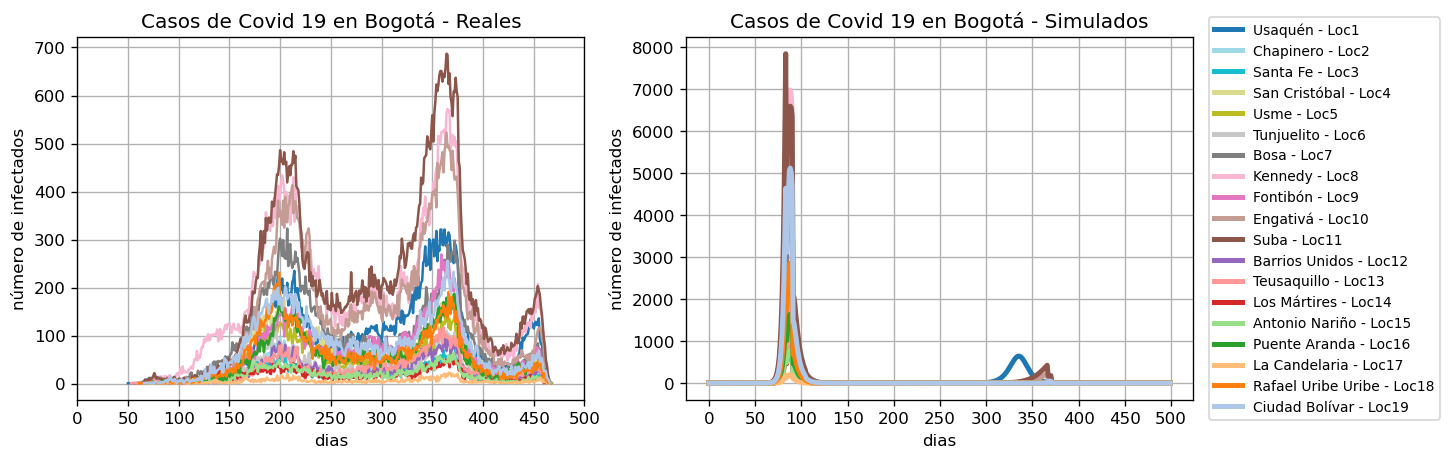

In [15]:
#--------------------------------------------------------------------------------------------------------------
infec = np.loadtxt("resultados.out")
infec = pd.DataFrame(infec, index=infec.T[0]).drop(0, axis=1)
infec = infec.sort_index()
#--------------------------------------------------------------------------------------------------------------
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, 19)]
fechas = Ncasos["dia"].apply(lambda x: (dia1+dt.timedelta(days=x)).strftime("%d/%m/%Y"))
c=0
#--------------------------------------------------------------------------------------------------------------
# Graficos
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(12,4),dpi=120)
for i in localidades["local_id"].values:
    #--------------------------------------------------------------------------------------------------------------
    # Casos reales
    loc = Ncasos[Ncasos["local_id"]==i] # Localidad i
    casos = loc["n_casos_real"].values
    tiempo = loc["dia"].values
    ax1.plot(tiempo, casos, label="Reales", color=colors[-c])
    #--------------------------------------------------------------------------------------------------------------
    # Casos simulaciones
    infectados = infec.T[i]
    t = np.arange(0, len(infectados))
    ax2.plot(t, symprob*infectados, lw=3, label=str(localidades["Localidad"][i-1]) + " - Loc"+str(i), color=colors[-c])
    ax2.legend(loc="right", bbox_to_anchor=(1.5,0.5), fontsize=8.3)
    #--------------------------------------------------------------------------------------------------------------
    # Propiedades gráficas
    ax1.set_title("Casos de Covid 19 en Bogotá - Reales")
    ax2.set_title("Casos de Covid 19 en Bogotá - Simulados")
    ax1.set_xlabel("dias")
    ax2.set_xlabel("dias")
    ax1.set_ylabel("número de infectados")
    ax2.set_ylabel("número de infectados")
    ax1.grid()
    ax2.grid()
    ax1.set_xlim(0,500)
    #ax2.set_xlim(0,500)
    ax1.set_xticks(np.linspace(0,500,11))
    ax2.set_xticks(np.linspace(0,500,11))
    #ax2.set_xlim(0,300)
    #ax2.set_ylim(0,5000)
    c+=1

"""
dia1 = pd.to_datetime("01/01/2020", format="%d/%m/%Y")
dias = lambda ax: [(dia1+dt.timedelta(days=i)).strftime("%d/%b/%Y") for i in ax.get_xticks()]
ax2.set_xticklabels(dias(ax2), rotation=60)
ax1.set_xticklabels(dias(ax1), rotation=60)
plt.show()
"""
""

In [11]:
def simule(x, grad):
    # Escribiendo archivo cfg.txt
    beta, symprob = x[0], x[1]
    write_config(beta, symprob)
    
    # Corriendo simulacion
    configs = sim.read_config('files/cfg.txt')
    sim.run_disease_simulation(configs, write_epi=True)

    # DataFrame de Infectados reales y simulados
    infec = np.loadtxt("resultados.out")
    infec = pd.DataFrame(infec, index=infec.T[0]).drop(0, axis=1)
    x, y = np.meshgrid(infec.columns, infec.index)
    infecs = pd.DataFrame(np.transpose([x.ravel(),y.ravel(),infec.values.ravel()]), 
                            columns=["dia", "local_id", "n_casos_sim"])
    Inf = pd.merge(infecs, Ncasos, on=['dia','local_id'],  how='right')
    
    # Error   
    Error = (Inf["n_casos_real"][60:260] - symprob*Inf["n_casos_sim"][60:260])**2
    Error = Error.sum().sum()/(260-60)/19
    return Error

In [12]:
# Optimizacion:

n = 2 # Numero de variables a optimizar : Beta y SymProb
Nitr = 1000 # Numero maximo de iteraciones 

inf = [0.5, 0.05] # Limites inferiores
sup = [5, 1]  # Limites superiores

opt = nlopt.opt(nlopt.LN_NELDERMEAD, n)
opt.set_lower_bounds(inf)
opt.set_upper_bounds(sup)
opt.set_maxeval(Nitr)
opt.set_min_objective(simule)
opt.set_xtol_rel(1e-5)
x0 = np.array([2.5, 0.15])
x = opt.optimize(x0)
x

array([3.34477299, 0.13967973])

## Gráficos reales vs simulaciones individules

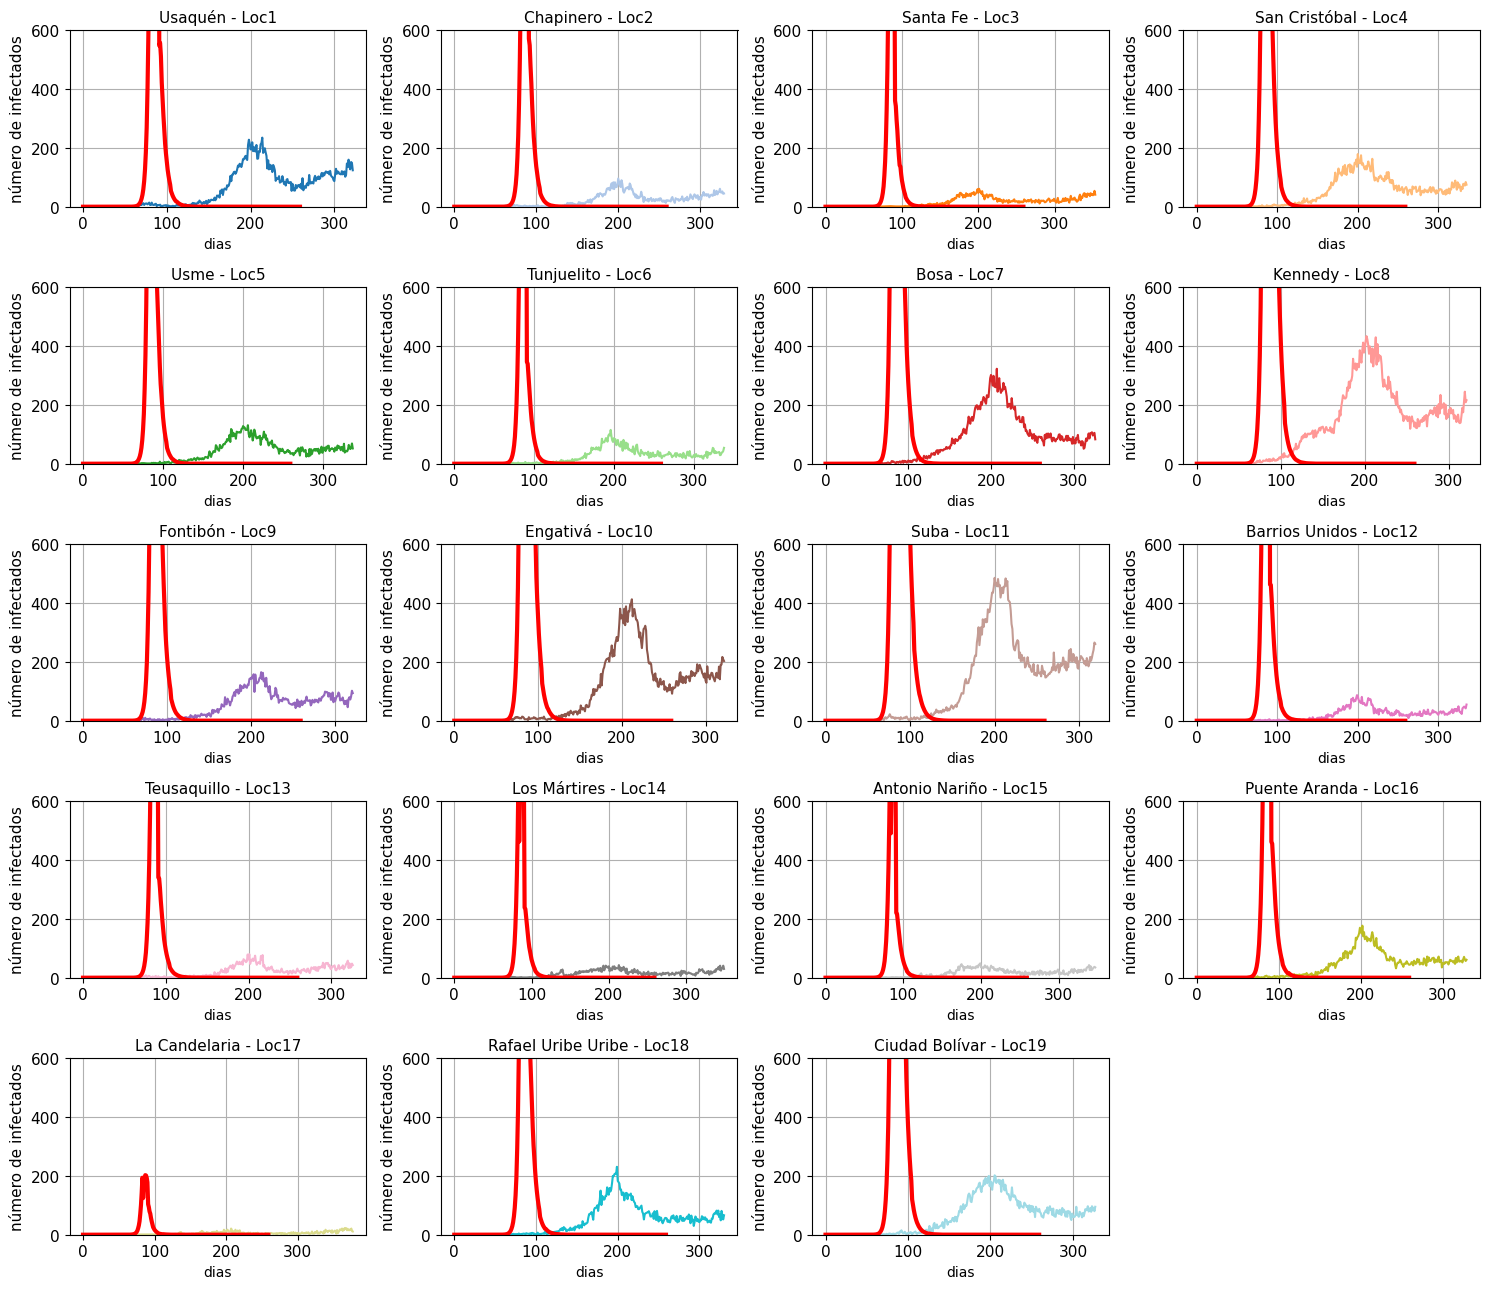

In [16]:
# Graficos
c=0
fig, ax = plt.subplots(5,4,figsize=(15,13),dpi=100)
ax = ax.reshape(-1)
for i in localidades["local_id"].values:
    l=i-1
    # Casos reales
    loc = Ncasos[Ncasos["local_id"]==i] # Localidad i
    tiempo = loc["dia"].values
    casos = loc["n_casos_real"].values
    ax[l].plot(tiempo[:260], casos[:260], label="Reales", color=colors[c])
    # Casos simulaciones
    infectados = infec.T[i]
    t = np.arange(0, len(infectados))
    ax[l].plot(t[:260],symprob*infectados[:260], label="Simulaciones", lw=3, color="red")
    # Propiedades gráficas
    ax[l].set_xlabel("dias")
    ax[l].set_title(str(localidades["Localidad"][i-1]) + " - Loc"+str(i), fontsize=11)
    ax[l].set_ylabel("número de infectados", fontsize=11)
    ax[l].tick_params(axis='x', labelsize=11)
    ax[l].tick_params(axis='y', labelsize=11)
    ax[l].grid()
    ax[l].set_ylim(0,600)
    c+=1
ax[-1].axis("off")
fig.tight_layout()

## Referencias

+ Análisis del Covid-19 por medio de un modelo SEIR  
    https://institucional.us.es/blogimus/2020/03/covid-19-analisis-por-medio-de-un-modelo-seir/
      
+ Modelo SEIR para Colombia: Medidas de mitigación del virus  
    https://www.eafit.edu.co/escuelas/economiayfinanzas/cief/Documents/informe-especial-2020-abril-2.pdf
      
+ shinySIR: Interactive plotting for infectious disease models  
    https://cran.r-project.org/web/packages/shinySIR/vignettes/Vignette.html